### Adversarial Knowledge distillation
#### Adversarial Knowledge Distillation for logits (04.12.2020)

In [1]:
import torch
import torchvision

from IPython.display import clear_output
from collections import OrderedDict,defaultdict
import time
import tqdm
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. Adversarial Knowledge Distillation with Vanilla GAN for logits

The following approach is termed as $\textbf{Adversarial Knowledge Distillation}$.
This approach is based on the following conception:

1. There is a teacher trained network with $\psi$ parameters.
2. There is a student not trained network with $\phi$ parameters.
3. There is a discriminator $\mathbb{D}$ that should be able distinguish logits of teacher $\mathcal{L}_{teacher}$ from logits of student $\mathcal{L}_{student}$

The training procedure is described as:
1. take the batch of objects(pictures) $x = \{ x_{1},...,x_{B}\}$, where B is a batch size.
2. take a teacher network trained and calculate its logits $\mathcal{L}_{teacher}(x_{1},...,x_{B})$ is termed $\textbf{true}$
3. take a student model untrained and calculate its logits on the same batch $\mathcal{L}_{student}(x_{1},..,x_{B})$ is termed $\textbf{fake}$
4. Do some steps with the discriminator to distinguish these true and fake logits with the following way:

$$ Loss_{1}(\theta) = - (\mathbb{E}_{true} \log \mathbb{D}_{\theta}(true) + \mathbb{E}_{fake}\log(1 - \mathbb{D}_{\theta}(fake))) \to \min_{\theta}$$

where $\theta$ is parameter of discriminator.

5. As soon as the critic becomes trained a little bit, one can perplex him via the maximization discriminator on fake logits and optimizing CrossEntropyLoss at the ame time, while parameters of discriminator are fixed

$$ Loss_{2}(\phi) = CrossEntropyLoss(\phi) - \mathbb{E}_{fake} \mathbb{D}_{\theta}(fake) \to \min_{\phi}$$

### 2. Формальная постановка задачи

$\textbf{Задача:}$ Рассматривается задача многоклассовой классификации. 

1. $\textbf{Моделью глубокого обучения}$ будем называть дифференцируемую по параметрам $w$ функцию $f(w,x)$ из множества признаковых описаний объекта во множество меток:
$$ f: \mathbb{W} \times \mathbb{X} \to \mathbb{Y} $$

Где $\mathbb{W}$ - это пространство параметров функции $f$


2. Модели глубокого обучения $f$ и $g$ называются $\textbf{неоднородными}$ , если число скрытых слоев этих моделей или число нейронов в них не эквивалентны друг другу.

Имеются две неоднородные модели  глубокого обучения $f(w_{t},x)$ и $g(w_{s},x)$, именуемые "модель учитель", пространство параметров которой является заранее оптимизированным, и " модель студент" с неоптимальными пространством собственных параметров соответсвенно.

3. Задано параметрическое распределение $q_{t}$ , моделирующеее выходы промежуточных слоев или их скрытые представления "модели учителя", включая логиты данной сети 

4. Задано параметрическое распределение $q_{s}$, моделирующее выходы промежуточных слоев или их скрытые представления"модели студента" , включая логиты данной сети

5. Задана параметрическая модель классификации $\mathbb{D}_{\theta}$, где $\theta$ - это элемент пространства параметров дискриминатора, призванного разделять скрытые представления двух заданных неоднородных моделей (в частности, логиты этих сетей).

Ставится задача двухуровневая задача оптмизации:
$$ \theta^{*} = \arg \min_{\theta} (\mathbb{E}_{t \sim q_{t}(x,w_{t})} \log \mathbb{D}_{\theta}(t(x,w_{t})) + \mathbb{E}_{s \sim q_{s}(x,w_{s})}\log(1 - \mathbb{D}_{\theta}(s(x,w_{s}))))$$ 
$$ w_{s}^{*} = \arg\max_{w_{s}}  \mathbb{E}_{s \sim q_{s}(x,w_{s})} \mathbb{D}_{\theta^{*}}( s(x,w_{s})) - \sum_{k}\mathcal{L}(y_{k} | g(w_{s},x_{k})) $$

Где $\mathcal{L}(y_{k}  |  g(w_{s},x_{k}))$ - это ошибка модели на объекте $x_{k}$.


$\textbf{Цель:}$  Обучить "модель студент"  для задачи многоклассовой классификации при помощи минимизации кросс-энтропии между предсказанными метками $\mathbb{\hat{Y}}$ "моделью студентом" и действительными метками $\mathbb{Y}$ на тех же объектах $\mathbb{x}$ и обучения дискриминатора $\mathbb{D}_{\theta}$ , который должен быть способен различать логиты "модели студента" $\mathbb{\hat{L}}$ от логитов "модели учителя" $\mathbb{L}$.

"Модель студент" представляет собой генератор, поскольку именно она генерирует логиты  $\mathbb{\hat{L}}$, которые дискриминатор $\mathbb{D}_{\theta}$ должен определять как "фейковые". 

$\textbf{Процесс обучения:}$

1. Берем батч объектов $x_{batch} = \{x_{1},...,x_{B}\} $, где  $B$ размер батча
2. Получаем выход из функции "модели учителя" $f(\psi,x_{batch})$ как логиты $\mathbb{L}(x_{batch},\psi)$
3. Получаем выход из функции "модели студента" $g(\phi,x_{batch})$ как логиты $\mathbb{\hat{L}}(x_{batch},\phi)$
4. Делаем несколько шагов дискриминатора, минимизируя следующую функцию потерь по парметрам дискриминатора:
$$  Loss_{1}(\theta) = - (\mathbb{E}_{\mathbb{L}} \log \mathbb{D}_{\theta}(\mathbb{L}(x_{batch},\psi)) + \mathbb{E}_{\mathbb{\hat{L}}}\log(1 - \mathbb{D}_{\theta}(\mathbb{\hat{L}}(x_{batch},\phi)))) \to \min_{\theta}$$ 
5. Переходим ко второму шагу адверсариального обученя, а именно максимизаци значения дискриминатора на "фейковых" объектах, при этом мы также минимизуруем кросс энтропию между предсказания "модели студента" и действительными метками по парметрам "модели студента":
$$ Loss_{2}(\phi) = CrossEntropyLoss(\phi) - \mathbb{E}_{\mathbb{\hat{L}}} \mathbb{D}_{\theta}(\mathbb{\hat{L}}(\phi,x_{batch})) \to \min_{\phi}$$

In [94]:
class MLP(torch.nn.Module):
    
    def __init__(self, input_size, hidden_dims, n_classes, label):
        super().__init__()
        
        assert isinstance(hidden_dims, list)
        assert label in ['teacher','student','discriminator']
        
        if label == 'discriminator' and not(n_classes == 1):
            raise AssertionError ("Discriminator should return only one class insted of {}".format(n_classes))
        
        self.input_size = input_size
        self.hidden_dims = hidden_dims
        self.n_classes = n_classes
        
        model = []
        hidden = [input_size] + hidden_dims + [n_classes]
        for current_layer, next_layer, idx in zip(hidden, hidden[1:], range(1, len(hidden) + 1)  ):
            model.extend([(label + '_linear_' + str(idx), torch.nn.Linear(in_features = current_layer, out_features = next_layer, bias = False )),\
                          (label + '_relu_' + str(idx), torch.nn.ReLU())])
        
        #model.pop() # to remove final ReLU activation
        model.pop() # to remoove final BathcNorm1d
        self.net = torch.nn.Sequential(OrderedDict(model))
  
    def forward(self,x):
        x = x.view(-1,28*28) # for the discriminator x.view(-1,10)
        return self.net(x)

As soon as we define the multi-layer network, which teacher , student and discriminator are based on, one can download a dataset. For instance, this dataset may constitute $\textbf{MNIST}$.

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,),(0.5,))])
train_val_dataset = torchvision.datasets.MNIST(root='./data',train=True , transform = transform , download = True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform = transform, download = True)
train_dataset,val_dataset = torch.utils.data.random_split(train_val_dataset,[50000,10000])

Files already downloaded
Files already downloaded


In [5]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# torch.Size([batch,1,28,28])

Let's move on the following part of the experiment that deals with defining loss function of discriminator $\mathbb{D}$.

As we have already said our discriminator returns one logit, because it is inherited from MLP class. However, there should be probability of logit in loss of discriminator like as follow:

The loss of a discriminator
$$
\mathcal{L}_{\mathrm{dis}}(\theta)
    = - \tfrac12 \mathbb{E}_{\mathcal{L}_{\mathrm{teacher}}}
        \log \sigma(\mathbb{D}_{\theta}(\mathcal{L}_{\mathrm{teacher}}))
    - \tfrac12 \mathbb{E}_{ \mathcal{L}_{\mathrm{student}}}
        \log (1 - \sigma(\mathbb{D}_{\theta}(\mathcal{L}_{\mathrm{student}})))
\,. $$

However, this expression is not stable for high($\to$ $\infty$) and low ($\to$ -$\infty$) values for the reason exponent in denominator of sigmoid.

The sigmoid function is:
$$
\sigma(p)
    = \frac1{1 + e^{-p}}
    \,, \sigma(-p) = 1-\sigma(p)$$


However, we have
$$
\ell(y, p)
    = - y \log \sigma(p) - (1-y) \log (1 - \sigma(p))
    %% p > 0
    % = y \log (1+e^{-p}) + (1-y) \log (1+e^p)
    % = \log (1+e^{-p}) + p - y p
    %% p < 0
    % = y \log (1+e^{-p}) + (1-y) \log (1+e^p)
    % = \log (1+e^p) - y p
    = \log (1+e^{-\lvert p\rvert}) - y p + \max\{p, 0\}
\,, $$
which is implemented in `torch.nn.BCEWithLogitsLoss`, so we don't have to do this ourselves.



In [80]:
def discriminator_loss(discriminator,true_data, fake_data):
    ### descitption ###
    # 1. this function should return loss via the LogSumExp trick
    # 2. as well as prob of fake and prob of true 
    out_true = discriminator(true_data)
    out_fake = discriminator(fake_data)
    
    loss_real = torch.nn.BCEWithLogitsLoss(reduction='mean')(out_true, torch.full_like(out_true,0.99))
    loss_fake = torch.nn.BCEWithLogitsLoss(reduction='mean')(out_fake, torch.full_like(out_fake,0.))
    
    return 0.5*(loss_real + loss_fake), discriminator(true_data).sigmoid().mean() , discriminator(fake_data).sigmoid().mean() 

In [81]:
def make_step(discriminator, discr_loss_fn, true_data, fake_data, optimizer):
    optimizer.zero_grad()
    loss, prob_true, prob_fake = discr_loss_fn(discriminator,true_data,fake_data)
    loss.backward() # ???
    optimizer.step()
    return loss, prob_true, prob_fake

In [82]:
def train_discriminator(discriminator,
                             discr_loss_fn,
                             true_data, # logits of teacher
                             fake_data, # logits of student
                             discr_optimizer):
    #discriminator.train()
    loss, prob_true, prob_fake = make_step(discriminator, discr_loss_fn, true_data, fake_data, discr_optimizer)
    return {"loss": loss,
           "prob_true":prob_true,
           "prob_fake":prob_fake}

In [91]:
N_CLASSES = 10
HIDDEN_DISCR = [100,500,100]
LR_DISCR = 1e-3

discriminator = MLP(N_CLASSES, HIDDEN_DISCR,1,'discriminator')
discr_optimizer = torch.optim.Adam(discriminator.parameters(),lr=LR_DISCR)

# this code is performed after trainig of the teacher
fake_data = torch.randn(1,10)
true_data = teacher_trained(next(iter(train_loader))[0][0])


In [92]:
train_discriminator(discriminator, discriminator_loss, true_data, fake_data, discr_optimizer)

{'loss': tensor(0.6119, grad_fn=<MulBackward0>),
 'prob_true': tensor(0.5862, grad_fn=<MeanBackward0>),
 'prob_fake': tensor(0.4966, grad_fn=<MeanBackward0>)}

Now, one can train the teacher model, so write the code for this

In [10]:
def train_model(model,
                optimizer_teacher,
               train_loader,
               criterion,
               val_loader, num_epochs):

    history = defaultdict(lambda: defaultdict(list))
    
    for epoch in tqdm_notebook(range(num_epochs)):
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()
        model.train()
        
        for batch_x,batch_y in tqdm_notebook(train_loader):
            
            optimizer_teacher.zero_grad()
            logits = model(batch_x)
            #print(logits.shape)
            loss = criterion(logits, batch_y.long())
            loss.backward()
            optimizer_teacher.step()
            
            train_loss += np.sum(loss.detach().numpy())
            y_pred = logits.max(1)[1].detach().numpy()
            train_acc += np.mean(batch_y.numpy() == y_pred)
            
        # calculate and save to history
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        
        model.eval()
        with torch.no_grad():
            for batch_x,batch_y in tqdm_notebook(val_loader):
                logits = model(batch_x)
                loss_val = criterion(logits,batch_y.long())
                
                val_loss += np.sum(loss_val.numpy())
                y_pred = logits.max(1)[1].numpy()
                val_acc += np.mean(batch_y.numpy() == y_pred)
            
            #calculate and save to history
            val_loss /= len(val_loader)
            val_acc /= len(val_loader) 
            history['loss']['val'].append(val_loss)
            history['acc']['val'].append(val_acc)

            clear_output()
        
            #print results after each epoch
            print("Epoch {} of {} took {:.3f}s".format(
              epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
            print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
            print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
            print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
            plot_learning_curves(history)
            
        
        
    return model, history

In [11]:
def plot_learning_curves(history):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig = plt.figure(figsize=(50, 30))

    plt.subplot(2,1,1)
    plt.title('Loss', fontsize=15)

    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='validation')

    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(2,1,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='validation')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()
    plt.show()

Epoch 5 of 5 took 89.359s
  training loss (in-iteration): 	0.085736
  validation loss (in-iteration): 	0.110835
  training accuracy: 			97.35 %
  validation accuracy: 			96.89 %


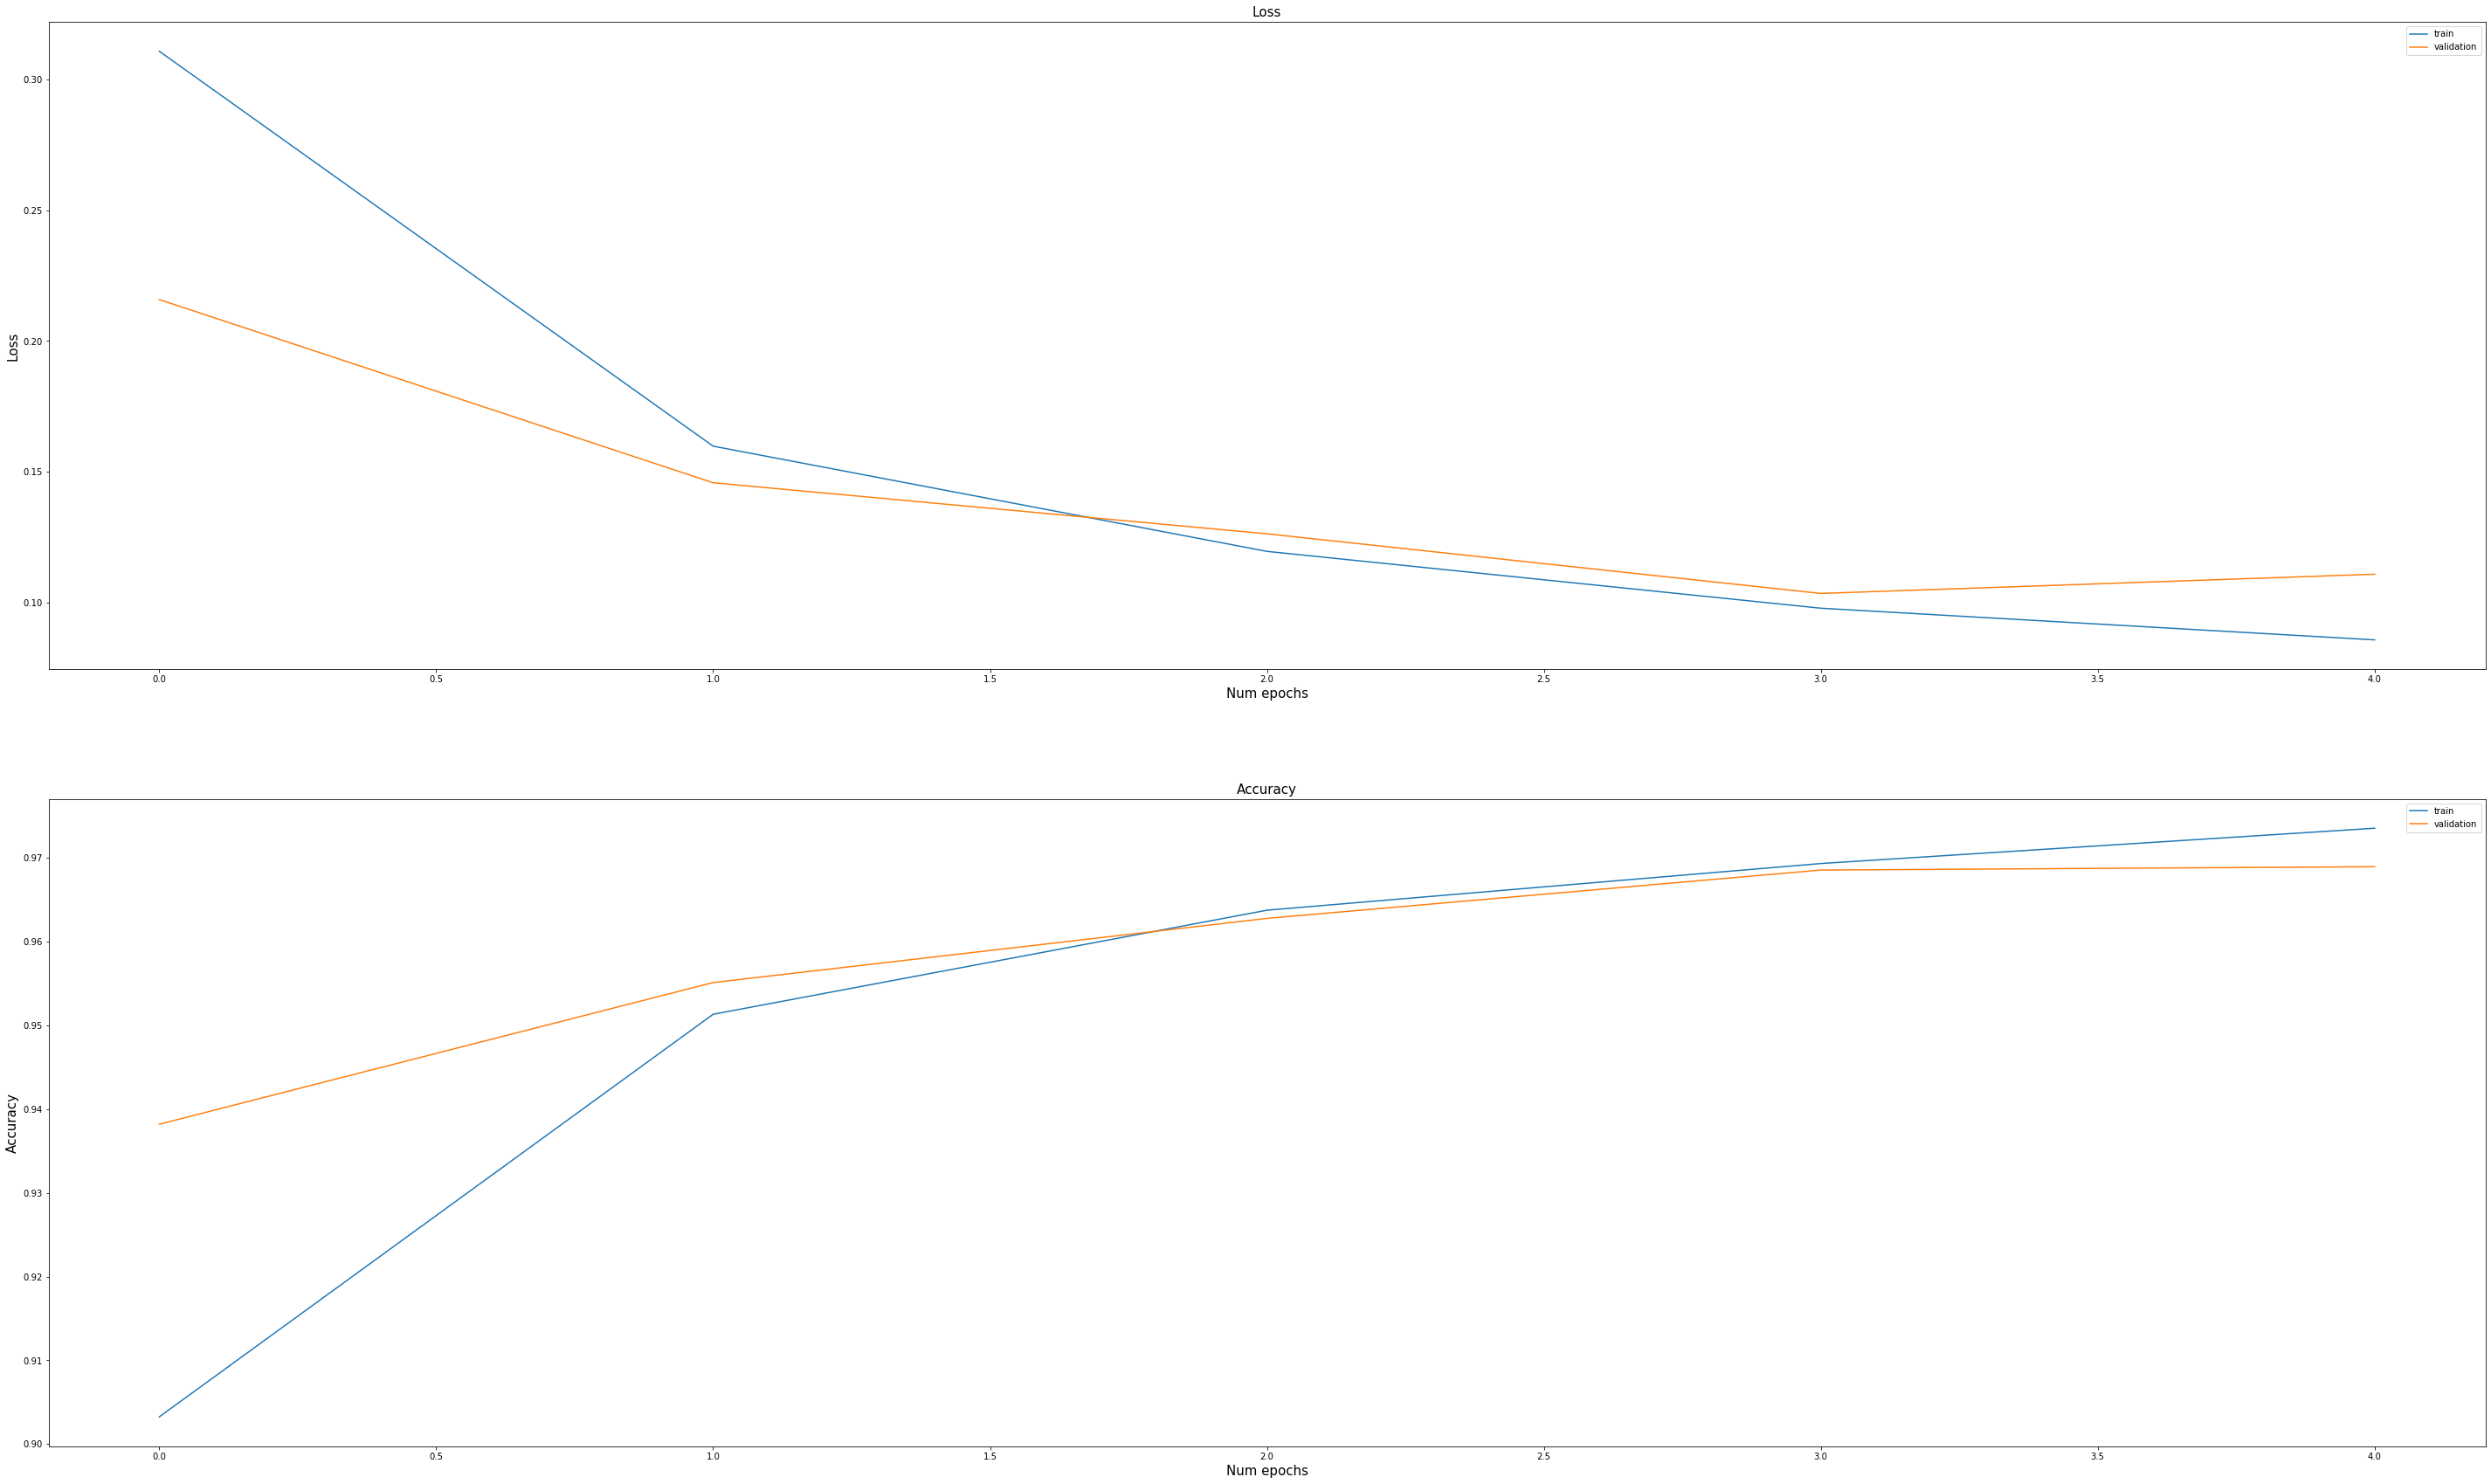

In [13]:
INPUT_DIM  = 28*28
HIDDEN     = [1000,1000,512]
NUM_CLASSES = 10
LR= 1e-3 # may learning rate annealing with weight_decay
criterion = torch.nn.CrossEntropyLoss()
NUM_EPOCHS = 5

teacher = MLP(INPUT_DIM, HIDDEN , NUM_CLASSES, 'teacher')
optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=LR)
teacher_trained, history = train_model(teacher,optimizer_teacher,train_loader,criterion,val_loader,NUM_EPOCHS)

Now, we have trained teacher model $\textbf{teacher_trained}$. Now one can write pypline for adversarial knowledge distillation.

Now, one can move on to actual training of knowledge Distillation.

In [24]:
def plot_learning_curves(history):
    '''
     
    This function is aimed to show up at all loss and accuracy (metrics) during the training of the model

    :param history: (dict)
        accuracy and loss on the training and validation
    '''
    # sns.set_style(style='whitegrid')

    fig = plt.figure(figsize=(50, 30))

    plt.subplot(2,2,1)
    plt.title('Loss', fontsize=15)

    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='validation')

    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='validation')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Num epochs', fontsize=15)
    plt.legend()

    plt.subplot(2,2,3)
    plt.title('Discriminator loss',fontsize = 15)
    plt.plot(history['discrim_loss']['discrim_loss'], color = 'olive', label = 'loss of discriminator')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Num iterations', fontsize=15)
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.title('Probabilities of logits',fontsize = 15)
    plt.plot(history['prob_true']['prob_true'], color = 'brown', label = 'teachers logits')
    plt.plot(history['prob_fake']['prob_fake'],color = 'teal',label ='students logits')
    plt.ylabel('Probability', fontsize=15)
    plt.xlabel('Num iterations', fontsize=15)
    plt.ylim([0,1])
    plt.legend()

    plt.show()

In [78]:
def train_student(student,
                 teacher,
                 discriminator,
                 train_loader,
                 student_optimizer,
                 discr_optimizer,
                 discr_loss,
                 val_loader,
                 criterion,
                 num_epochs):
    
    history = defaultdict(lambda: defaultdict(list))
    
     
    
     
    for epoch in tqdm_notebook(range(num_epochs)):
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        discrim_loss = []
        probs_true = []
        probs_fake = []
        
        
        
        start_time = time.time()
        
         
        teacher.eval()
        
        for batch_x, batch_y in tqdm_notebook(train_loader):
            
            student.train()
            discriminator.eval()
            
            student_optimizer.zero_grad()
            
            
            student_logits = student(batch_x)
            teacher_logits = teacher(batch_x).detach()
            
            # pseudo-generator loss
            generator_loss = - discriminator(student_logits).mean()
            
            loss_student_task = criterion(student_logits, batch_y.long())
            full_loss = 1*loss_student_task + 0.1*generator_loss
            full_loss.backward()
            student_optimizer.step()
            
            #loss_student += np.sum(loss_student_task.detach().numpt())
            train_loss += np.sum(full_loss.detach().numpy()) 
            y_pred = student_logits.max(1)[1].detach().numpy()
            train_acc += np.mean(batch_y.numpy() == y_pred)
            
            # discriminator training
            student.eval()
            discriminator.train()
            
            discriminator_vocab = train_discriminator(discriminator, discr_loss, teacher_logits, student_logits.detach(),\
                                                      discr_optimizer)
            
            discrim_loss.append(discriminator_vocab['loss'].detach().numpy())
            probs_true.append(discriminator_vocab['prob_true'].detach().numpy())
            probs_fake.append(discriminator_vocab['prob_fake'].detach().numpy())
            
        
         
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        history['discrim_loss']['discrim_loss'].extend(discrim_loss)
        history['prob_true']['prob_true'].extend(probs_true)
        history['prob_fake']['prob_fake'].extend(probs_fake)
       
    
    
        with torch.no_grad():
            for batch_x,batch_y in  tqdm_notebook(val_loader):
                student_logits = student(batch_x).detach()
                loss_val = criterion(student_logits, batch_y.long())
                val_loss += np.sum(loss_val.detach().numpy())
                y_pred = student_logits.max(1)[1].detach().numpy()
                val_acc += np.mean(batch_y.numpy() == y_pred)
            
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()
        
        #print results after each epoch
        print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return student, history     

Epoch 10 of 10 took 56.536s
  training loss (in-iteration): 	0.097139
  validation loss (in-iteration): 	0.104658
  training accuracy: 			98.51 %
  validation accuracy: 			97.09 %


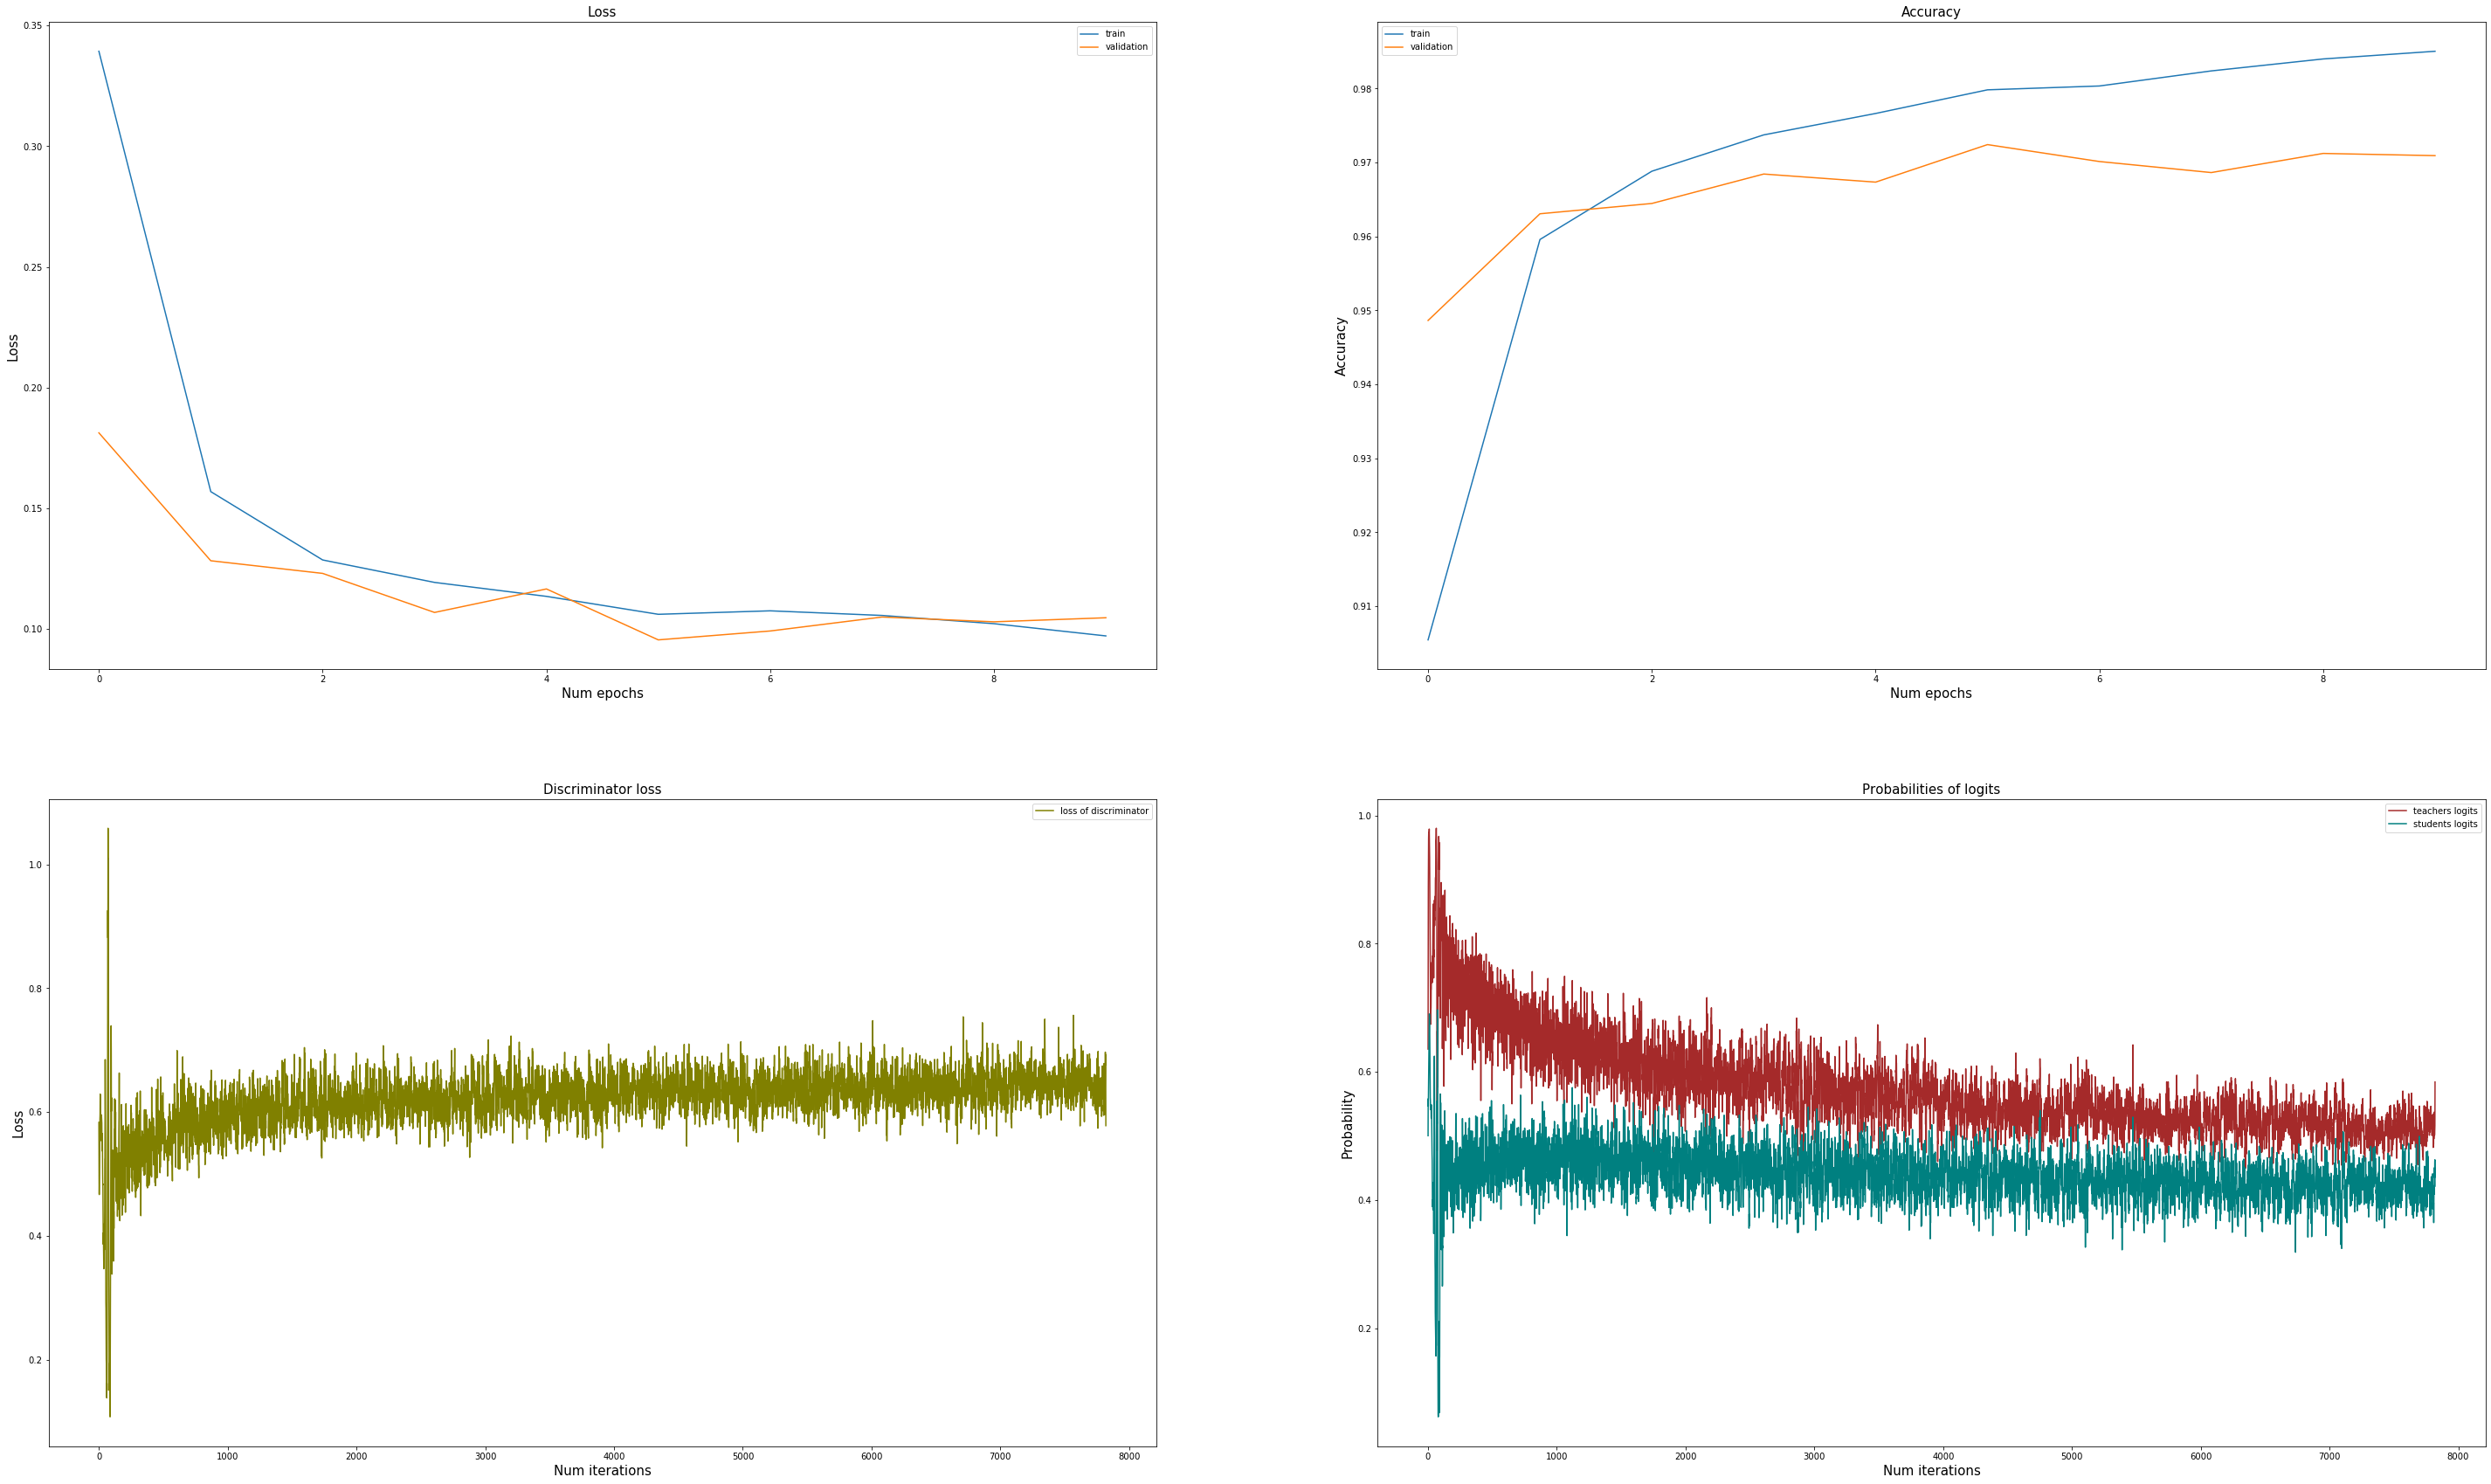

In [95]:
INPUT_STUDENT = 28*28
HIDDEN_STUDENT = [1000]
NUM_CLASSES = 10
LR_STUDENT = 1e-3
CRITERION = torch.nn.CrossEntropyLoss()
NUM_EPOCHS = 10

student = MLP(INPUT_STUDENT,HIDDEN_STUDENT,NUM_CLASSES,'student')
student_optimizer = torch.optim.Adam(student.parameters(),lr=LR_STUDENT)


student_trained, history = train_student(student,
                 teacher_trained,
                 discriminator,
                 train_loader,
                 student_optimizer,
                 discr_optimizer,
                 discriminator_loss,
                 val_loader,criterion,NUM_EPOCHS)